In [1]:
!pip install mlflow > /dev/null

In [2]:
!pip install kaggle > /dev/null

In [79]:
!pip install streamlit > /dev/null

In [3]:
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!npm install -g localtunnel >/dev/null

In [6]:
get_ipython().system_raw("mlflow ui --port 5000 &")
get_ipython().system_raw('lt --port 5000 >> url.txt 2>&1 &')

In [43]:
import seaborn as sns

In [7]:
import os
import random
import shutil
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mlflow import log_metric, log_param, log_artifacts, log_params, log_metrics
import mlflow
from tqdm import tqdm
random.seed(12)
torch.manual_seed(12)
np.random.seed(12)

### Data Loading

In [8]:
!rm -r test
!rm -r train
!rm -r val

rm: cannot remove 'test': No such file or directory
rm: cannot remove 'train': No such file or directory
rm: cannot remove 'val': No such file or directory


In [9]:
!kaggle datasets download whenamancodes/wild-animals-images 

100% 0.98G/0.98G [00:44<00:00, 24.8MB/s]
100% 0.98G/0.98G [00:44<00:00, 23.8MB/s]


In [10]:
!unzip wild-animals-images.zip -d ../animal-data >/dev/null

In [11]:
for img in ['../animal-data/hyena-resize-512/resize-512/00000224_512resized.png','../animal-data/cheetah-resize-512/resize-512/00000244_512resized.png']:
  os.remove(img)

In [12]:
split_size = {'train':0.7,
              'test' : 0.15,
              'val': 0.15}
for class_i in os.listdir('../animal-data/'):
        if class_i.endswith('512'):
          class_name = class_i.split('-')[0]
          resize_dir = os.listdir(f'../animal-data/{class_i}')[-1]
          images  = os.listdir(f'../animal-data/{class_i}/{resize_dir}')
          random.Random(2).shuffle(images)
          curr_index = 0
          for curr_split in ['train','test','val']:
            os.makedirs(f'./{curr_split}/{class_name}')
            for img in images[curr_index : curr_index + int(len(images) * split_size[curr_split])]:
              shutil.move(f'../animal-data/{class_i}/{resize_dir}/{img}',f'./{curr_split}/{class_name}/')
            curr_index += int(len(images) * split_size[curr_split])

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Helper Functions

In [14]:
criterion = nn.CrossEntropyLoss()
## Source [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html]
## Refered the syntax for writing training loop from above source
def train_step(model,optimizer,inputs,labels):
    ## train a batch
    model.train()
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def validation(model,val_dataloader):
    #validation loss for the model
    model.eval()
    val_loss = 0
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
          outputs = model(inputs)
          loss =  criterion(outputs, labels)
        val_loss += loss.item()
    return val_loss

def test(model,test_dataloader):
  model.eval()
  total_examples = 0
  correct_pred = 0
  for inputs,labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = model(inputs).argmax(1).cpu()
      total_examples += outputs.shape[0]
      correct_pred += (outputs.numpy() == labels.cpu().numpy()).sum()
  acc = correct_pred/total_examples
  return acc

### Data Preprocessing

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((128,128)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16
train_set = ImageFolder(root='./train', transform=transform)
val_set = ImageFolder(root='./val', transform=transform)
test_set = ImageFolder(root='./test', transform=transform)

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=False, num_workers=1)
classes = train_set.classes

tensor([2, 0, 3, 2, 0, 1, 3, 0, 2, 5, 0, 1, 3, 2, 4, 0])


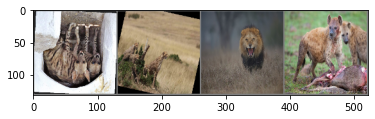

hyena cheetah lion  hyena


In [65]:
## Source [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html]
## this code block to visualize images from data loader is taken from above source
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
print(labels)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[:4][j]]:5s}' for j in range(4)))

In [18]:
for class_i in os.listdir('./test'):
  class_dir = f'./test/{class_i}'
  print(f'Instances of {class_i} : {len(os.listdir(class_dir))}')

Instances of cheetah : 51
Instances of fox : 37
Instances of lion : 44
Instances of hyena : 45
Instances of wolf : 39
Instances of tiger : 40


## Baseline Model

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Model().to(device)

In [20]:
model_params  = {'data_augmentation':False,'transfer learning':False,'conv and pool layers' : 3,'fully_connected_layers' : 2,'filters_size' : '3,5,5','batch_size' : 16}
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=model_params['batch_size'],shuffle=True, num_workers=1)
optimizer = optim.Adam(model.parameters(),0.001)

In [21]:
with mlflow.start_run(run_name='Baseline_CNN',nested=True):
  log_params(model_params)
  step = 0
  for epoch in range(10):  # loop over the dataset multiple times
      running_loss = 0.0
      for inputs, labels in tqdm(train_dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          running_loss += train_step(model,optimizer,inputs,labels)
          if step % 10 == 0 and step!=0: 
              val_loss = validation(model,val_dataloader)
              train_val_loss = {
                  'train_loss': running_loss/10,
                  'val_loss' : val_loss/len(val_dataloader)
              }
              log_metrics(train_val_loss,step)
              running_loss = 0.0
          step += 1
  test_acc = test(model.to(device),test_dataloader)
  log_metrics({'Test Accuracy':test_acc})
  mlflow.pytorch.log_model(model,artifact_path='model')

 93%|█████████▎| 71/76 [00:43<00:06,  1.37s/it]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 18%|█▊        | 14/76 [00:05<00:15,  3.90it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  4%|▍         | 3/76 [00:00<00:14,  5.18it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 41%|████      | 31/76 [00:13<00:12,  3.60it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted

## Data Augmentation

In [61]:
transforms_aug = transforms.RandomApply(torch.nn.ModuleList([
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomAffine(20)
 ]), p=0.4)
transform_train = transforms.Compose(
    [ 
      transforms_aug,
      transforms.ToTensor(),
      transforms.Resize((128,128)),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = ImageFolder(root='./train', transform=transform_train)

In [23]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Model().to(device)

In [62]:
model_params  = {'data_augmentation':True,'transfer learning':False,'conv and pool layers' : 3,'fully_connected_layers' : 2,'filters_size' : '3,5,5','batch_size' : 16}
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=model_params['batch_size'],shuffle=True, num_workers=1)
optimizer = optim.Adam(model.parameters(),0.001)

In [25]:
with mlflow.start_run(run_name='Baseline_CNN_with_data_aug',nested=True):
  log_params(model_params)
  step = 0
  for epoch in range(10):  # loop over the dataset multiple times
      running_loss = 0.0
      for inputs, labels in tqdm(train_dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          running_loss += train_step(model,optimizer,inputs,labels)
          if step % 10 == 0 and step!=0: 
              val_loss = validation(model,val_dataloader)
              train_val_loss = {
                  'train_loss': running_loss/10,
                  'val_loss' : val_loss/len(val_dataloader)
              }
              log_metrics(train_val_loss,step)
              running_loss = 0.0
          step += 1
  test_acc = test(model.to(device),test_dataloader)
  log_metrics({'Test Accuracy':test_acc})
  mlflow.pytorch.log_model(model,artifact_path='model')

 18%|█▊        | 14/76 [00:05<00:33,  1.84it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 32%|███▏      | 24/76 [00:10<00:12,  4.21it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 11%|█         | 8/76 [00:01<00:13,  4.95it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 17%|█▋        | 13/76 [00:08<01:13,  1.17s/it]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted

## Transfer Learning

In [26]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

train_set = ImageFolder(root='./train', transform=transform)
val_set = ImageFolder(root='./val', transform=transform)
test_set = ImageFolder(root='./test', transform=transform)

In [27]:
pretrained_model = torchvision.models.vgg13(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

In [28]:
class Model(nn.Module):
    def __init__(self,pretrained,num_classes):
        super().__init__()
        for param in pretrained.parameters():
            param.requires_grad = False
        pretrained.classifier[6] = nn.Linear(4096,num_classes)
        self.model = pretrained

    def forward(self, x):
        output = self.model(x)
        return output
model = Model(pretrained_model,6).to(device)

In [29]:
model_params  = {'data_augmentation':False,'transfer learning':True,'conv and pool layers' : 10,'fully_connected_layers' : 3,'batch_size' : 16}
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=model_params['batch_size'],shuffle=True, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=model_params['batch_size'],shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=model_params['batch_size'],shuffle=False, num_workers=1)
optimizer = optim.Adam(model.parameters())

In [30]:
with mlflow.start_run(run_name='VGG_transfer_learning',nested=True):
  log_params(model_params)
  step = 0
  for epoch in range(5):  # loop over the dataset multiple times
      running_loss = 0.0
      for inputs, labels in tqdm(train_dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          running_loss += train_step(model,optimizer,inputs,labels)
          if step % 10 == 0 and step!=0: 
              val_loss = validation(model,val_dataloader)
              train_val_loss = {
                  'train_loss': running_loss/10,
                  'val_loss' : val_loss/len(val_dataloader)
              }
              log_metrics(train_val_loss,step)
              running_loss = 0.0
          step += 1
  test_acc = test(model.to(device),test_dataloader)
  log_metrics({'Test Accuracy':test_acc})
  mlflow.pytorch.log_model(model,artifact_path='model')

  1%|▏         | 1/76 [00:00<00:36,  2.04it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  7%|▋         | 5/76 [00:04<01:46,  1.51s/it]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 11%|█         | 8/76 [00:01<00:13,  4.87it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  0%|          | 0/76 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA im

In [31]:
test_acc = test(model.to(device),test_dataloader)

## Transfer learning with Classical ML Model

In [32]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

train_set = ImageFolder(root='./train', transform=transform)
val_set = ImageFolder(root='./val', transform=transform)
test_set = ImageFolder(root='./test', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=model_params['batch_size'],shuffle=True, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=model_params['batch_size'],shuffle=False, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=model_params['batch_size'],shuffle=False, num_workers=1)


In [33]:
feature_extractor = torchvision.models.vgg13(pretrained=True)
feature_extractor.classifier = feature_extractor.classifier[:4]

In [34]:
def get_features(datalaoder,model):
  data = None
  label = None
  model.to(device)
  model.eval()
  for inputs, labels in tqdm(datalaoder):
          inputs = inputs.to(device)
          with torch.no_grad():
            if data is not None: data = np.append(data,model(inputs).cpu().numpy(),axis=0)
            else: data = model(inputs).cpu().numpy()
          if label is not None: label = np.append(label,labels,axis=0)
          else: label = labels.numpy()
  return data,label

In [35]:
train_data,train_label = get_features(train_dataloader,feature_extractor)
val_data,val_label = get_features(val_dataloader,feature_extractor)
test_data,test_label = get_features(test_dataloader,feature_extractor)

 36%|███▌      | 27/76 [00:06<00:10,  4.78it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 16/16 [00:03<00:00,  4.66it/s]


SVM

In [36]:
from sklearn.svm import SVC

In [37]:
model_params  = {'transfer learning':True}

In [38]:
with mlflow.start_run(run_name='SVM_VGG_features',nested=True):
  sv_clf = SVC()
  sv_clf.fit(train_data,train_label)
  test_predict = sv_clf.predict(test_data)
  test_acc = (test_predict == test_label).sum()/len(test_predict)
  log_metrics({'Test Accuracy':test_acc})


### KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
with mlflow.start_run(run_name='KNN_VGG_features',nested=True):
  neigh = KNeighborsClassifier(n_neighbors=5)
  neigh.fit(train_data,train_label)
  test_predict = neigh.predict(test_data)
  test_acc = (test_predict == test_label).sum()/len(test_predict)
  log_metrics({'Test Accuracy':test_acc})

## Compare performances

In [41]:
mlflow.search_runs()[['tags.mlflow.runName','metrics.Test Accuracy']]

,tags.mlflow.runName,metrics.Test Accuracy
0,KNN_VGG_features,0.988281
1,SVM_VGG_features,0.988281
2,VGG_transfer_learning,0.992188
3,Baseline_CNN_with_data_aug,0.597656
4,Baseline_CNN,0.582031


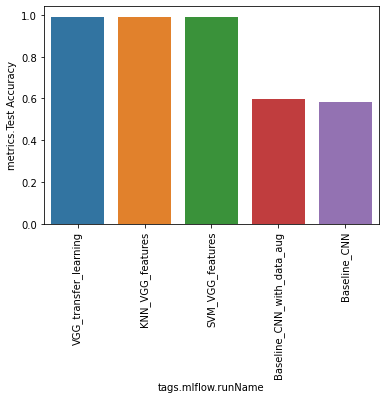

In [49]:
acc = mlflow.search_runs()[['tags.mlflow.runName','metrics.Test Accuracy']]
ax = sns.barplot(x='tags.mlflow.runName',y='metrics.Test Accuracy',data=acc.sort_values('metrics.Test Accuracy',ascending=False))
ax.tick_params(axis='x', rotation=90)


In [58]:
time = mlflow.search_runs()[['tags.mlflow.runName','start_time','end_time']]
time['Training time'] = (time['end_time'] - time['start_time']).dt.seconds/60

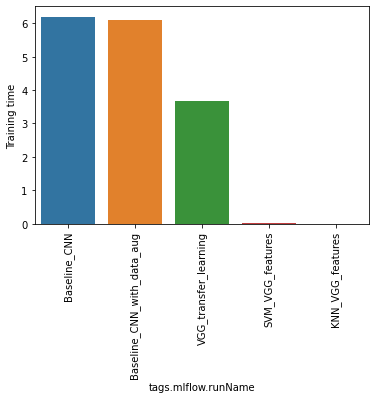

In [60]:
ax = sns.barplot(x='tags.mlflow.runName',y='Training time',data=time.sort_values('Training time',ascending=False))
ax.tick_params(axis='x', rotation=90)

In [ ]:
acc.sort_values()

## Streamlit app

In [76]:
!mkdir models

In [77]:
df = mlflow.search_runs()
artifcat_uri = df[df['tags.mlflow.runName']=='VGG_transfer_learning']['artifact_uri'].values[0]
model_path = f'{artifcat_uri}/model/data/model.pth'
shutil.copy(model_path,'models/')

'models/model.pth'

In [74]:
artifcat_uri

'./mlruns/0/8e48b541de06451b8404f7037eea6ab3/artifacts'

In [84]:
get_ipython().system_raw("streamlit run app.py --server.port 5001 &")
get_ipython().system_raw('lt --port 5001 >> url.txt 2>&1 &')